In [55]:
#Notes: 
#Updated one has gradient descent with rmsprop optimization, which gave an improvement of 
# 0.5%, which is good, I suppose. Also, small batch sizes give better results than large 
# batch size

In [1]:
#Load the data from train file
import pandas as pd
import numpy as np

def load_mnist_data():
    
    data=pd.read_csv('train.csv', sep=',').as_matrix()
    data.shape
    N = data.shape[0]
    n_train = int((N*90)/100)
    X_train = np.column_stack((data[:n_train,1:], np.ones((n_train,1))))
    Y_train = data[:n_train,0]
    
    X_test = np.column_stack((data[n_train:,1:], np.ones((N-n_train,1))))
    Y_test = data[n_train:,0]

    C = 10
    d = X_train.shape[1]
    return data, N, n_train, X_train, Y_train, X_test, Y_test, C, d

In [2]:
#split the data into training and testing data
data, N, n_train, X_train, Y_train, X_test, Y_test, C, d = load_mnist_data()

In [3]:
%matplotlib inline

1

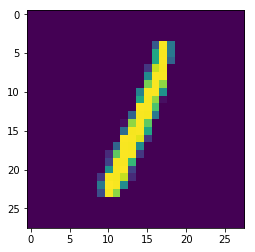

In [4]:
#plot the image just so that you can see how they are

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

n = 38
imgplot = plt.imshow(X_train[n,:-1].reshape(28,28))
Y_train[n]

In [5]:
#theta = np.random.rand(C,d)/1000
theta = np.zeros((C,d))

In [6]:
import random
# First implement a gradient checker by filling in the following functions
def gradcheck_naive(f, x):
    """ 
    Gradient check for a function f 
    - f should be a function that takes a single argument and outputs the cost and its gradients
    - x is the point (numpy array) to check the gradient at
    """ 

    rndstate = random.getstate()
    random.setstate(rndstate)  
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-10

    # Iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        
        ### YOUR CODE HERE: try modifying x[ix] with h defined above to compute numerical gradients
        ### make sure you call random.setstate(rndstate) before calling f(x) each time, this will make it 
        ### possible to test cost functions with built in randomness later
        
        x[ix] = x[ix]+h
        
        random.setstate(rndstate)
        fx1,grad1 = f(x)
        numgrad = (fx1-fx)/h
        
        x[ix] = x[ix]-h
        
        ### END YOUR CODE

        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print( "Gradient check failed.")
            print( "First gradient error found at index %s" % str(ix))
            print( "Your gradient: %f \t Numerical gradient: %f" % (grad[ix], numgrad))
            return
        
        it.iternext() # Step to next dimension

    print( "Gradient check passed!")

In [7]:
def compute_probability_matrix(theta, X):
    prod = X.dot(theta.T)
    exp = np.exp(prod-np.max(prod, axis=1).reshape(-1,1))
    norm_const = np.sum(exp,axis=1).reshape(-1,1)
    prob_matrix = exp/(norm_const)
    return prob_matrix

def compute_probability_array(theta, X, Y):
    prob_matrix = compute_probability_matrix(theta, X)
    k = prob_matrix.shape[0]
    return prob_matrix[np.arange(k),Y]

#computes sum log p(y=y(i)|x(i)) for all i belonging to the training set
def compute_log_entropy(theta, X, Y):
    prob_array = compute_probability_array(theta, X, Y)
    N = X.shape[0]
    return np.sum(np.log(prob_array))/N

def compute_gradient(theta, X, Y):
    prob_matrix = compute_probability_matrix(theta, X)
    k = prob_matrix.shape[0]
    prob_matrix[np.arange(k),Y] -= 1
    N = X.shape[0]
    return -prob_matrix.T.dot(X)/N

def cost_grad(theta, X, Y):
    cost = compute_log_entropy(theta, X, Y)
    grad = compute_gradient(theta, X, Y)
    return cost, grad

def predict(theta, X):
    prob_matrix = compute_probability_matrix(theta, X)
    return np.argmax(prob_matrix, axis=1)

"""
theta_toy = np.random.rand(2,2)
X_toy = np.array([[1,2],[2,1],[3,2]])
Y_toy = np.array([0,1,0])
print(theta_toy.shape, X_toy.shape, Y_toy.shape)
print (cost_grad(theta_toy, X_toy, Y_toy))
gradcheck_naive(lambda t : cost_grad(t, X_toy, Y_toy), theta_toy, 1e-6)
"""
print(Y_train.shape)
gradcheck_naive(lambda t : cost_grad(t, X_train[1:10], Y_train[1:10]), theta)

(37800,)
Gradient check passed!


In [ ]:
def gradient_descent(f, predict, theta, Xr, Yr, Xe, Ye, batch_size=5, max_iterations=100, print_iteration=10, learning_rate=0.0001):
    N_train = Xr.shape[0]
    batch_count = int(N_train/batch_size)
    it = 0
    training_error = []
    testing_error = []
    cache = np.zeros((theta.shape))
    while it < max_iterations:
        #pick a batch
        batch = np.random.choice(N_train, batch_count)
        X, Y = Xr[batch], Yr[batch]
        
        cost, grad = f(theta, X, Y)
        a = 0.99
        cache = (1-a)*grad**2 + a*cache
        theta += learning_rate*grad /(np.sqrt(cache) + 1e-7)
        
        if it%print_iteration == 0:
            training_cost = f(theta, Xr, Yr)[0]
            testing_cost = f(theta, Xe, Ye)[0]
            training_error.append(training_cost)
            testing_error.append(testing_cost)
            print("Iteration %d\t Training cost %f\t Testing cost %f\t"%(it, training_cost, testing_cost))
        
        it += 1
    
    Y_testp = predict(theta, Xe)
    Y_trainp = predict(theta, Xr)

    test_accuracy = np.mean(Y_testp==Ye)*100
    train_accuracy = np.mean(Y_trainp==Yr)*100
    return training_error, testing_error, theta, train_accuracy, test_accuracy

theta = np.zeros((C,d))
training_error, testing_error, theta, train_accuracy, test_accuracy = gradient_descent(cost_grad, predict, theta, X_train, Y_train, X_test, Y_test,
                                                        print_iteration=1000, max_iterations=36000,learning_rate=1e-6)

x = range(len(training_error))
plt.plot(x, training_error, x, testing_error)
plt.show()

print(test_accuracy, train_accuracy)

Iteration 0	 Training cost -2.174744	 Testing cost -2.171365	


In [30]:
Y_testp = predict(theta, X_test)
Y_trainp = predict(theta, X_train)

test_accuracy = np.mean(Y_testp==Y_test)*100
train_accuracy = np.mean(Y_trainp==Y_train)*100
print(test_accuracy, train_accuracy)

91.1666666667 91.0386904762


In [47]:
X_Kaggle=pd.read_csv('test.csv', sep=',').as_matrix()
X_Kaggle = np.column_stack((X_Kaggle, np.ones((28000,1))))
Y_Kaggle = predict(theta, X_Kaggle)
dataframe = pd.DataFrame({"ImageId":np.arange(28000)+1,"Label":Y_Kaggle})
dataframe.to_csv('submit.csv', index=False)


In [220]:
#pairwise classification
def matching_indices(Y, i, j, n):
    x = [p for p in range(n) if Y[p] == i]
    y = [p for p in range(n) if Y[p] == j]
    return x,y

params = []
n_test = N-n_train
i = 0
j = 4
for i in range(10):
    params.append([])
    for j in range(i):
        theta = np.zeros((2,d))
        x, y = matching_indices(Y_train, i, j, n_train)
        x_t, y_t = matching_indices(Y_test, i, j, n_test)
        xy = x+y
        xy_t = x_t+y_t
        Y_train_xy = np.copy(Y_train[xy])
        X_train_xy = np.copy(X_train[xy])
        Y_test_xy = np.copy(Y_test[xy_t])
        X_test_xy = np.copy(X_test[xy_t])

        x, y = matching_indices(Y_train_xy, i, j, Y_train_xy.shape[0])
        x_t, y_t = matching_indices(Y_test_xy, i, j, Y_test_xy.shape[0])
        Y_train_xy[x] = 0
        Y_train_xy[y] = 1
        Y_test_xy[x_t] = 0
        Y_test_xy[y_t] = 1
        training_error, testing_error, theta, train_accuracy, test_accuracy = gradient_descent(cost_grad, predict, theta, X_train_xy, Y_train_xy,
                                                                X_test_xy, Y_test_xy, 
                                                                print_iteration=1000000, max_iterations=100000,learning_rate=1e-5)

        x = range(len(training_error))
        #plt.plot(x, training_error, x, testing_error)
        #plt.show()
        params[i].append(theta)
        print(train_accuracy, test_accuracy)


99.7884114583 99.7380239521
99.0034364261 98.5536359984
99.1487311275 99.2789373814
99.4748433 99.0310077519
98.5893168489 98.4959647836
94.6532999165 94.4946913095
99.6004863644 99.4278708623
99.5619016713 99.5372155804
97.7050864874 97.9668049793
99.0712597096 98.8804478209
98.2094411286 97.3728106756
99.1238416175 99.2531446541
96.3286401711 95.3833121559
91.1837021426 90.7422512235
98.3777937996 97.6714100906
98.3561169753 97.9518072289
99.5796281326 99.6206373293
97.9013820167 97.2686506319
99.0410497981 98.820754717
98.6029665402 97.926171713
96.4811490126 95.5546147333
99.4274166386 99.3063583815
98.8335435057 99.0514410799
97.5083056478 97.8498827209
98.1648369654 97.885994715
97.985563203 97.6152623211
99.0225170187 98.7434130523
99.6822211072 99.6483001172
99.280322977 99.0392313851
97.378338522 97.3146747352
95.4663436581 95.3677366924
93.7052200614 93.3385579937
98.8278516445 98.1810665564
94.3695335277 93.9662447257
98.3966538864 98.2940698619
98.2363913855 98.2859368913
9

In [247]:
def predict_pairwise(params, X):
    N = X.shape[0]
    Y = np.zeros((N,d))
    for i in range(10):
        for j in range(i):
            prob_matrix = compute_probability_matrix(params[i][j], X)
            k = [k for k in range(N) if prob_matrix[k][0] > 0.8]
            l = [l for l in range(N) if prob_matrix[l][1] > 0.8]
            Y[k,i] += 1
            Y[l,j] += 1
            
    return np.argmax(Y, axis=1)

Y_testp = predict_pairwise(params, X_test)
Y_trainp = predict_pairwise(params, X_train)

test_accuracy = np.mean(Y_testp==Y_test)*100
train_accuracy = np.mean(Y_trainp==Y_train)*100
print("Train Accuracy %f, \tTest Accuracy %f"%(train_accuracy,test_accuracy))


Train Accuracy 91.142857, 	Test Accuracy 90.460317


In [240]:
X_Kaggle=pd.read_csv('test.csv', sep=',').as_matrix()
X_Kaggle = np.column_stack((X_Kaggle, np.ones((28000,1))))
Y_Kaggle = predict_pairwise(params, X_Kaggle)
dataframe = pd.DataFrame({"ImageId":np.arange(28000)+1,"Label":Y_Kaggle})
dataframe.to_csv('submit_pairwise.csv', index=False)
